In [1]:
!python --version

Python 3.12.4


# Importación de librerías

In [1]:
from datetime import datetime, timedelta

import pandas as pd

from copy import copy as cp

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error as rootmse

import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.callbacks import TFMProgressBar
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, TransformerModel, Prophet, BlockRNNModel, NBEATSModel
from darts.metrics import rmse
from darts.utils.statistics import check_seasonality, plot_acf
import darts.utils.timeseries_generation as tg
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood
from darts.timeseries import concatenate

from neuralprophet import NeuralProphet, utils



import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


# Carga de datos

In [3]:
def tratamiento(fichero):
    dataframe = pd.read_excel(fichero)
    dataframe = dataframe.rename({'clave1':'fecha', 'uniTotal':'unidades'}, axis=1)
    dataframe['fecha'] = pd.to_datetime(dataframe['fecha'], format="%Y%m%d")
    dataframe = dataframe.set_index(['fecha'])
    dataframe = dataframe.resample('D').first()
    dataframe.fillna(value=0, inplace=True)
    dataframe = dataframe.groupby(pd.Grouper(freq='B'))
    dataframe = dataframe.sum()
    dataframe[dataframe['unidades'] < 0] = 0
    dataframe = dataframe["2010-01-01":"2024-06-30"]
    name = fichero[fichero.find('/')+1:fichero.find('.')]
    return name, dataframe

def agrupar(ficheros: list):
    df = pd.DataFrame()
    lista = []
    for archivo in ficheros:
        name, aux = tratamiento(archivo)
        aux = aux.rename({'unidades':name}, axis=1)
  
      df = pd.concat([df, aux], axis=1)
        lista.append(name)
    return df, lista

def grafico(dataframe):
    fig, ax = plt.subplots()
    ax.plot(dataframe)
    ax.minorticks_on()
    ax.grid(which='major', alpha = 0.65, linestyle='-')
    ax.grid(which='minor', alpha = 0.25, linestyle='--')
    fig.autofmt_xdate()


#df = tratamiento('data/filtros.xlsx')

#df = tratamiento('data/discos.xlsx')

#df = tratamiento('data/pastillas.xlsx')

# name, df = tratamiento('data/baterias.xlsx') 

df, names = agrupar(['data/filtros.xlsx', 'data/baterias.xlsx'])

df = pd.read_csv('data/meteo_olvera.csv', decimal=',')
df['fecha'] = pd.to_datetime(df2['fecha'], format="%Y-%m-%d")
df.set_index('fecha', inplace=True)
df = df[['tmed', 'tmin', 'tmax', 'prec', 'dir', 'velmedia', 'hrMedia']]
df2 = df2.resample('B').first()
df2 = df2.fillna(method='backfill')
df = pd.concat([df, df2], axis=1)

df = df.reset_index()

train_df = df[:-130]
test_df = df[-130:]

scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(train_df[['unidades']])


# Creacion de clase TimeSeries

In [4]:
cols = ['tmed', 'tmin', 'tmax', 'prec', 'dir', 'velmedia', 'hrMedia']

train = TimeSeries.from_dataframe(train_df, time_col='fecha', value_cols=names+cols)
test = TimeSeries.from_dataframe(test_df, time_col='fecha', value_cols=names+cols)

transformer = Scaler(scaler)
train = transformer.fit_transform(train)
test = transformer.transform(test)
train = train.add_holidays(country_code='ES', prov='AN')

# Definición de modelos

In [5]:
epochs = 200
batch = 256

mod_blockrnn = BlockRNNModel(
    model='RNN',
    input_chunk_length=60,
    output_chunk_length=60,
    hidden_dim=25,
    n_rnn_layers=2,
    dropout=0.1,
    n_epochs=epochs,
    batch_size=batch,
    #optimizer_kwargs={"lr": 1e-3},
    show_warnings=True,
    model_name='RNN',
    #pl_trainer_kwargs={"precision": '64', "accelerator": "gpu", "devices": -1, "auto_select_gpus": True} 
    pl_trainer_kwargs={"precision": '64', "accelerator": "cpu"} 
)

mod_blockrnn_multi = cp(mod_blockrnn)

mod_blocklstm = BlockRNNModel(
    model='LSTM',
    input_chunk_length=60,
    output_chunk_length=60,
    hidden_dim=25,
    n_rnn_layers=2,
    dropout=0.1,
    n_epochs=epochs,
    batch_size=batch,
    #optimizer_kwargs={"lr": 1e-3},
    show_warnings=True,
    model_name='LSTM',
    pl_trainer_kwargs={"precision": '64', "accelerator": "cpu"} 
)
mod_blocklstm_multi = cp(mod_blocklstm)

mod_blockgru = BlockRNNModel(
    model='GRU',
    input_chunk_length=60,
    output_chunk_length=60,
    hidden_dim=25,
    n_rnn_layers=2,
    dropout=0.1,
    n_epochs=epochs,
    batch_size=batch,
    #optimizer_kwargs={"lr": 1e-3},
    show_warnings=True,
    model_name='GRU',
    pl_trainer_kwargs={"precision": '64', "accelerator": "cpu"} 
)
mod_blockgru_multi = cp(mod_blockgru)

mod_prophet = Prophet(
    add_seasonalities=None, 
    country_holidays='ES', 
    suppress_stdout_stderror=True, 
    add_encoders=None, 
    cap=None, 
    floor=None
)

mod_neuralprophet = NeuralProphet()

mod_nbeats = NBEATSModel(
    input_chunk_length=60,
    output_chunk_length=60,
    dropout=0.1,
    n_epochs=epochs,
    show_warnings=True,
    batch_size=batch,
    model_name='LSTM',
    pl_trainer_kwargs={"precision": '64', "accelerator": "cpu"} 
)

mod_nbeats_multi = cp(mod_nbeats)

# Entrenamiento o carga de modelos univariable


In [28]:
# # mod_blockrnn.fit(train['unidades'])
# # mod_blockrnn.save('models/blockrnn')
# mod_blockrnn = BlockRNNModel.load('models/blockrnn')

# # mod_blocklstm.fit(train['unidades'])
# # mod_blocklstm.save('models/blocklstm')
# mod_blocklstm = BlockRNNModel.load('models/blocklstm')

# # mod_blockgru.fit(train['unidades'])
# # mod_blockgru.save('models/blockgru')
# mod_blockgru = BlockRNNModel.load('models/blockgru')

# mod_prophet.fit(train['unidades'])
# mod_prophet.save('models/prophet')
# mod_prophet = Prophet.load('models/prophet')

# # mod_neuralprophet.fit(train_df[['fecha','unidades']].rename({'fecha':'ds', 'unidades':'y'}, axis=1))
# # utils.save(mod_neuralprophet, 'models/neuralprophet')
# mod_neuralprophet = utils.load('models/neuralprophet')

# # mod_nbeats.fit(train['unidades'])
# # mod_nbeats.save('models/nbeats')
# mod_nbeats = NBEATSModel.load('models/nbeats')

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.973% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 80
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (239). The results might not be optimal.


Finding best initial lr:   0%|          | 0/239 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.231% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.231% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


Predicting: 58it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
0,2024-01-01,0.0,48.790421,25.645348,-3.249312,26.394384
1,2024-01-02,46.0,49.413662,25.648117,-3.039501,26.805048
2,2024-01-03,52.0,48.717308,25.650887,-2.821206,25.887630
3,2024-01-04,70.0,48.204041,25.653662,-2.595083,25.145466
4,2024-01-05,41.0,50.895260,25.656431,-2.363155,27.601984
...,...,...,...,...,...,...
125,2024-06-24,65.0,55.712456,26.130196,3.236652,26.345610
126,2024-06-25,88.0,56.166698,26.132971,3.260535,26.773197
127,2024-06-26,60.0,55.329563,26.135740,3.284805,25.909016
128,2024-06-27,51.0,54.512367,26.138510,3.308887,25.064970


# Entrenamiento o carga de modelos multivariable


In [17]:
# mod_blockrnn_multi.fit(train)
# mod_blockrnn_multi.save('models/blockrnn_multi')
mod_blockrnn_multi = BlockRNNModel.load('models/blockrnn_multi')

# mod_blocklstm_multi.fit(train)
# mod_blocklstm_multi.save('models/blocklstm_multi')
mod_blocklstm_multi = BlockRNNModel.load('models/blocklstm_multi')

# mod_blockgru_multi.fit(train)
# mod_blockgru_multi.save('models/blockgru_multi')
mod_blockgru_multi = BlockRNNModel.load('models/blockgru_multi')

# mod_nbeats_multi.fit(train)
# mod_nbeats_multi.save('models/nbeats_multi')
mod_nbeats_multi = NBEATSModel.load('models/nbeats_multi')

# Predicción

In [18]:
models = [mod_blockrnn, mod_blocklstm, mod_blockgru, mod_prophet, mod_nbeats, mod_blockrnn_multi, mod_blocklstm_multi, mod_blockgru_multi, mod_nbeats_multi]
names = ['RNN', 'LSTM', 'GRU', 'Prophet', 'N-Beats', 'RNN-M', 'LSTM-M', 'GRU-M', 'N-Beats-M']

#test['unidades'].plot(label='mediciones')
resultados = test['unidades'].pd_dataframe()
errores = pd.DataFrame()

# Se realizan las predicciones y calcula el error RMSE
for i, model in enumerate(models):
    print(names[i])
    pred = model.predict(n=130)
    predicion = pred['unidades'].pd_dataframe().rename({'unidades':names[i]}, axis=1)
    resultados = pd.concat([resultados, predicion], axis=1)
    err = rmse(pred['unidades'], test['unidades'])
    errores = pd.concat([errores, pd.DataFrame({names[i]:[err]}, index=['Diario_escalado'])],axis=1)
    #pred['unidades'].plot(label=names[i])

# Se desescala las predicciones y calcula el error RMSE desescalado
errores_aux = pd.DataFrame()
for columna in resultados.columns:
    resultados[columna] = scaler.inverse_transform(resultados[[columna]])
    if columna == 'unidades':
        continue
    err=rootmse(resultados['unidades'], resultados[columna])
    errores_aux = pd.concat([errores_aux, pd.DataFrame({columna:[err]}, index=['Diario'])],axis=1)
errores = pd.concat([errores, errores_aux])

# Predicciones para NeuralProphet
predicion = mod_neuralprophet.predict(test_df[['fecha','unidades']].rename({'fecha':'ds', 'unidades':'y'}, axis=1))
predicion = predicion.rename({'ds':'fecha', 'yhat1':'NeuralProphet'}, axis=1)
predicion['fecha'] = pd.to_datetime(predicion['fecha'], format="%Y%m%d")
predicion = predicion.set_index(['fecha'])
predicion = predicion[['NeuralProphet']]
resultados = pd.concat([resultados, predicion], axis=1)
err=rootmse(resultados['unidades'], resultados[columna])
errores = pd.concat([errores, pd.DataFrame({'NeuralProphet':[err]}, index=['Diario'])],axis=1)

#Agrupación por mes
resultados_mes = resultados.groupby(pd.Grouper(freq='M'))
resultados_mes = resultados_mes.sum()

# Se calcula el error RMSE con los datos agrupados por meses
errores_aux = pd.DataFrame()
for columna in resultados_mes.columns:
    if columna == 'unidades':
        continue
    err=rootmse(resultados_mes['unidades'], resultados_mes[columna])
    errores_aux = pd.concat([errores_aux, pd.DataFrame({columna:[err]}, index=['Mensual'])],axis=1)
errores = pd.concat([errores, errores_aux])

RNN


Predicting: 0it [00:00, ?it/s]

LSTM


Predicting: 0it [00:00, ?it/s]

GRU


Predicting: 0it [00:00, ?it/s]

Prophet
N-Beats


Predicting: 0it [00:00, ?it/s]

RNN-M


Predicting: 0it [00:00, ?it/s]

LSTM-M


Predicting: 0it [00:00, ?it/s]

GRU-M


Predicting: 0it [00:00, ?it/s]

N-Beats-M


Predicting: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.231% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.231% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


Predicting: 0it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [19]:
resultados.to_csv('results/resultados.csv')
errores.fillna(0, inplace=True)
errores.to_csv('results/errores.csv')

# Zona de prueba de modelos

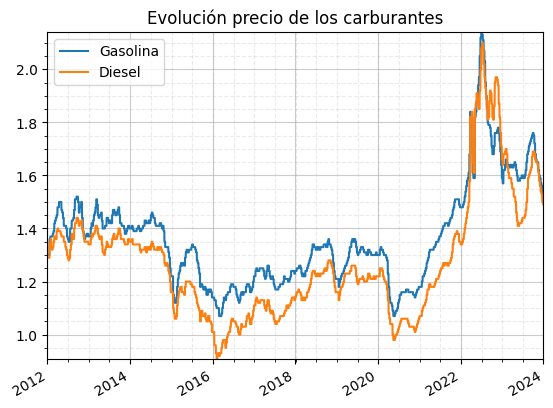

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Precio combustible
df = pd.read_csv('data/carburante.csv', decimal=',')
df['fecha'] = pd.to_datetime(df['fecha']+'0', format="%Y-%W%w")
df = df.set_index('fecha').sort_index()
df = df.resample('B').first().ffill()
df = df['2012':]

fig,ax = plt.subplots()
ax.plot(df)
ax.minorticks_on()
ax.grid(which='major', alpha = 0.65, linestyle='-')
ax.grid(which='minor', alpha = 0.25, linestyle='--')
ax.set_title(f'Evolución precio de los carburantes')
ax.legend(['Gasolina','Diesel'])
ax.axis(ymin=min(df.min()), ymax=max(df.max()), xmin=datetime(2012,1,1), xmax=datetime(2024,1,1))
fig.autofmt_xdate()
fig.savefig(f'/home/antonio/tfm/memoria/imagenes/grafica_carburantes.pdf')
